### AI1 Suggestion

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.3s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.7s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.8s
[CV] END ...................C=0.1, gamma=auto, k

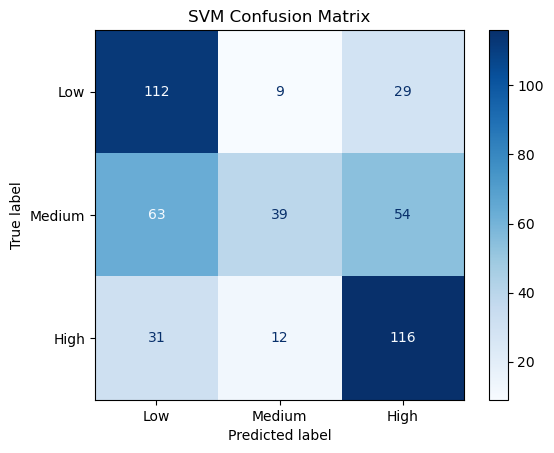

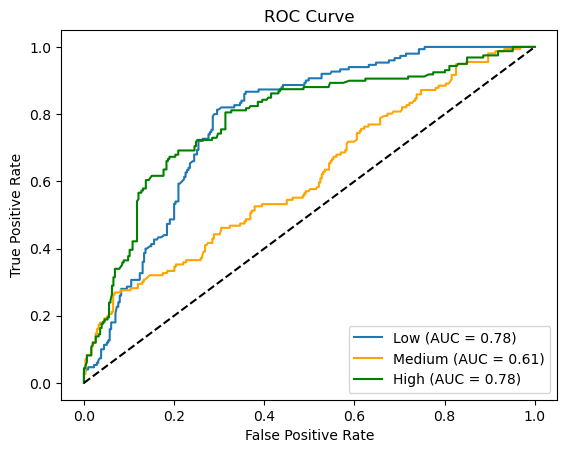

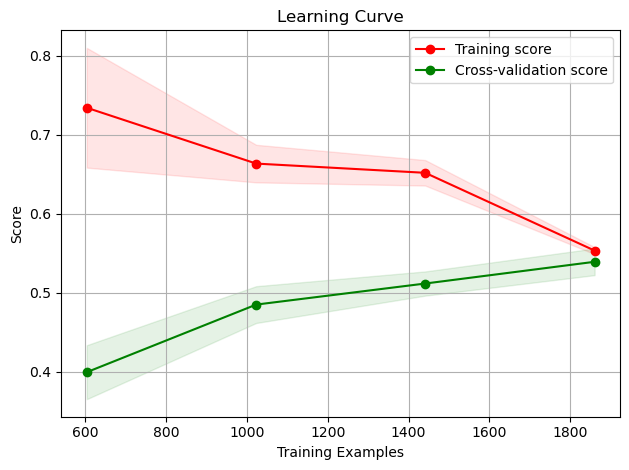

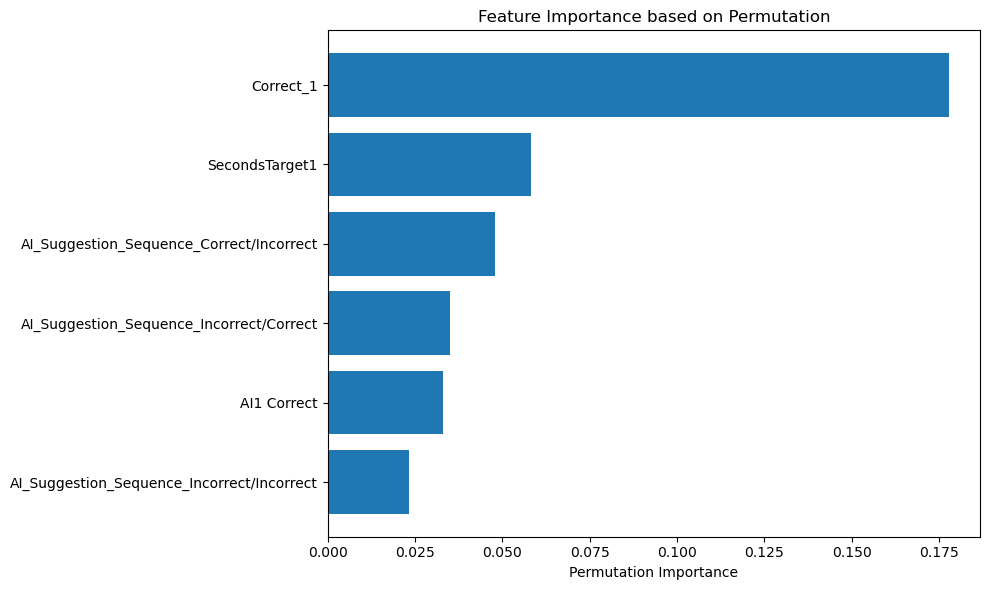

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE

# Load the combined behaviour data CSV file
combined_file_path = r'C:\Users\egtra\Documents\EEG-BCI\C4-CHI2025\ieee_tai\data\behaviour\combined_behaviour_remove_nan_response.csv'
df = pd.read_csv(combined_file_path)

# Step 1: Categorize the target (ConfidentLevel) into Low, Medium, High
def categorize_confidence(confidence_level):
    if confidence_level in [0, 1]:
        return 'Low'
    elif confidence_level in [2, 3]:
        return 'Medium'
    elif confidence_level in [4, 5]:
        return 'High'

# Apply the function to create the target variable
df['ConfidenceGroup'] = df['ConfidentLevel'].apply(categorize_confidence)

# Step 2: Select Features
features = ['SecondsTarget1', 'Correct_1', 'AI1 Correct']

# Step 3: Remove rows where 'SecondsTarget1', 'SecondsTarget2', or 'SecondsConfident' are 0
df = df[(df['SecondsTarget1'] != 0) & 
                          (df['SecondsTarget2'] != 0) & 
                          (df['SecondsConfident'] != 0)]


# Step 3: Remove rows with missing data
df = df.dropna(subset=features + ['ConfidenceGroup'])

X = df[features].apply(pd.to_numeric, errors='coerce')
y = df['ConfidenceGroup']

le = LabelEncoder()
le.classes_ = np.array(['Low', 'Medium', 'High'])
y_encoded = le.transform(y)

# == Nested cross-validation setup (4 outer, 3 inner) ==
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_accuracies = []
outer_aucs = []

for outer_train_idx, outer_test_idx in outer_cv.split(X, y_encoded):
    X_outer_train, X_outer_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
    y_outer_train, y_outer_test = y_encoded[outer_train_idx], y_encoded[outer_test_idx]

    # --- Inner cross-validation (hyperparameter tuning) ---
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    param_grid = [
        {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 1, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 10, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto'},
        {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'},
        {'C': 10, 'kernel': 'rbf', 'gamma': 'auto'},
    ]
    best_score = -np.inf
    best_params = None

    for params in param_grid:
        val_scores = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train, y_outer_train):
            X_inner_train, X_inner_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[inner_val_idx]
            y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]
            # === SMOTE only on the inner training set ===
            smote = SMOTE(random_state=42)
            X_inner_train_res, y_inner_train_res = smote.fit_resample(X_inner_train, y_inner_train)
            model = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'],
                        probability=True, random_state=42)
            model.fit(X_inner_train_res, y_inner_train_res)
            y_val_pred = model.predict(X_inner_val)
            acc = accuracy_score(y_inner_val, y_val_pred)
            val_scores.append(acc)
        avg_val_score = np.mean(val_scores)
        if avg_val_score > best_score:
            best_score = avg_val_score
            best_params = params

    # --- Retrain on full outer train set with best params, SMOTE again only on train ---
    smote = SMOTE(random_state=42)
    X_outer_train_res, y_outer_train_res = smote.fit_resample(X_outer_train, y_outer_train)
    final_model = SVC(**best_params, probability=True, random_state=42)
    final_model.fit(X_outer_train_res, y_outer_train_res)

    # --- Test on outer test fold ---
    y_outer_pred = final_model.predict(X_outer_test)
    acc = accuracy_score(y_outer_test, y_outer_pred)
    outer_accuracies.append(acc)

    # For multiclass AUC: need to binarize y
    y_test_bin = label_binarize(y_outer_test, classes=[0, 1, 2])
    y_proba = final_model.predict_proba(X_outer_test)
    auc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
    outer_aucs.append(auc)

    print(f"Outer fold accuracy: {acc:.4f}, AUC: {auc:.4f}, Params: {best_params}")

print(f"\nMean accuracy across outer folds: {np.mean(outer_accuracies):.4f} ± {np.std(outer_accuracies):.4f}")
print(f"Mean macro AUC across outer folds: {np.mean(outer_aucs):.4f} ± {np.std(outer_aucs):.4f}")


### AI2 Suggestion

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE

# Load the combined behaviour data CSV file
combined_file_path = r'C:\Users\egtra\Documents\EEG-BCI\C4-CHI2025\ieee_tai\data\behaviour\combined_behaviour_remove_nan_response.csv'
df = pd.read_csv(combined_file_path)

# Step 1: Categorize the target (ConfidentLevel) into Low, Medium, High
def categorize_confidence(confidence_level):
    if confidence_level in [0, 1]:
        return 'Low'
    elif confidence_level in [2, 3]:
        return 'Medium'
    elif confidence_level in [4, 5]:
        return 'High'

# Apply the function to create the target variable
df['ConfidenceGroup'] = df['ConfidentLevel'].apply(categorize_confidence)

# Step 2: Select Features
features = ['SecondsTarget2', 'Correct_2', 'AI2 Correct']

# Step 3: Remove rows where 'SecondsTarget1', 'SecondsTarget2', or 'SecondsConfident' are 0
df = df[(df['SecondsTarget1'] != 0) & 
                          (df['SecondsTarget2'] != 0) & 
                          (df['SecondsConfident'] != 0)]


# Step 3: Remove rows with missing data
df = df.dropna(subset=features + ['ConfidenceGroup'])

X = df[features].apply(pd.to_numeric, errors='coerce')
y = df['ConfidenceGroup']

le = LabelEncoder()
le.classes_ = np.array(['Low', 'Medium', 'High'])
y_encoded = le.transform(y)

# == Nested cross-validation setup (4 outer, 3 inner) ==
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_accuracies = []
outer_aucs = []

for outer_train_idx, outer_test_idx in outer_cv.split(X, y_encoded):
    X_outer_train, X_outer_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
    y_outer_train, y_outer_test = y_encoded[outer_train_idx], y_encoded[outer_test_idx]

    # --- Inner cross-validation (hyperparameter tuning) ---
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    param_grid = [
        {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 1, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 10, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto'},
        {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'},
        {'C': 10, 'kernel': 'rbf', 'gamma': 'auto'},
    ]
    best_score = -np.inf
    best_params = None

    for params in param_grid:
        val_scores = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train, y_outer_train):
            X_inner_train, X_inner_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[inner_val_idx]
            y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]
            # === SMOTE only on the inner training set ===
            smote = SMOTE(random_state=42)
            X_inner_train_res, y_inner_train_res = smote.fit_resample(X_inner_train, y_inner_train)
            model = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'],
                        probability=True, random_state=42)
            model.fit(X_inner_train_res, y_inner_train_res)
            y_val_pred = model.predict(X_inner_val)
            acc = accuracy_score(y_inner_val, y_val_pred)
            val_scores.append(acc)
        avg_val_score = np.mean(val_scores)
        if avg_val_score > best_score:
            best_score = avg_val_score
            best_params = params

    # --- Retrain on full outer train set with best params, SMOTE again only on train ---
    smote = SMOTE(random_state=42)
    X_outer_train_res, y_outer_train_res = smote.fit_resample(X_outer_train, y_outer_train)
    final_model = SVC(**best_params, probability=True, random_state=42)
    final_model.fit(X_outer_train_res, y_outer_train_res)

    # --- Test on outer test fold ---
    y_outer_pred = final_model.predict(X_outer_test)
    acc = accuracy_score(y_outer_test, y_outer_pred)
    outer_accuracies.append(acc)

    # For multiclass AUC: need to binarize y
    y_test_bin = label_binarize(y_outer_test, classes=[0, 1, 2])
    y_proba = final_model.predict_proba(X_outer_test)
    auc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
    outer_aucs.append(auc)

    print(f"Outer fold accuracy: {acc:.4f}, AUC: {auc:.4f}, Params: {best_params}")

print(f"\nMean accuracy across outer folds: {np.mean(outer_accuracies):.4f} ± {np.std(outer_accuracies):.4f}")
print(f"Mean macro AUC across outer folds: {np.mean(outer_aucs):.4f} ± {np.std(outer_aucs):.4f}")


Outer fold accuracy: 0.7153, AUC: 0.6873, Params: {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}
Outer fold accuracy: 0.6607, AUC: 0.6636, Params: {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'}
Outer fold accuracy: 0.6750, AUC: 0.6449, Params: {'C': 10, 'kernel': 'rbf', 'gamma': 'auto'}
Outer fold accuracy: 0.7000, AUC: 0.6582, Params: {'C': 10, 'kernel': 'rbf', 'gamma': 'auto'}

Mean accuracy across outer folds: 0.6878 ± 0.0212
Mean macro AUC across outer folds: 0.6635 ± 0.0153


### AI1+AI2 Suggestion

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE

# Load the combined behaviour data CSV file
combined_file_path = r'C:\Users\egtra\Documents\EEG-BCI\C4-CHI2025\ieee_tai\data\behaviour\combined_behaviour_remove_nan_response.csv'
df = pd.read_csv(combined_file_path)

# Step 1: Categorize the target (ConfidentLevel) into Low, Medium, High
def categorize_confidence(confidence_level):
    if confidence_level in [0, 1]:
        return 'Low'
    elif confidence_level in [2, 3]:
        return 'Medium'
    elif confidence_level in [4, 5]:
        return 'High'

df['ConfidenceGroup'] = df['ConfidentLevel'].apply(categorize_confidence)

# Step 2: Feature selection (edit for your features)
features = ['SecondsTarget2', 'Correct_2', 'AI2 Correct',
            'SecondsTarget1', 'Correct_1', 'AI1 Correct']
dummy_columns = [col for col in df.columns if 'AI_Suggestion_Sequence' in col]
features = features + dummy_columns

# Step 3: Remove rows with missing data
df = df.dropna(subset=features + ['ConfidenceGroup'])

X = df[features].apply(pd.to_numeric, errors='coerce')
y = df['ConfidenceGroup']

le = LabelEncoder()
le.classes_ = np.array(['Low', 'Medium', 'High'])
y_encoded = le.transform(y)

# == Nested cross-validation setup (4 outer, 3 inner) ==
outer_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
outer_accuracies = []
outer_aucs = []

for outer_train_idx, outer_test_idx in outer_cv.split(X, y_encoded):
    X_outer_train, X_outer_test = X.iloc[outer_train_idx], X.iloc[outer_test_idx]
    y_outer_train, y_outer_test = y_encoded[outer_train_idx], y_encoded[outer_test_idx]

    # --- Inner cross-validation (hyperparameter tuning) ---
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    param_grid = [
        {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 1, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 10, 'kernel': 'linear', 'gamma': 'scale'},
        {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 1, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 10, 'kernel': 'rbf', 'gamma': 'scale'},
        {'C': 0.1, 'kernel': 'rbf', 'gamma': 'auto'},
        {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'},
        {'C': 10, 'kernel': 'rbf', 'gamma': 'auto'},
    ]
    best_score = -np.inf
    best_params = None

    for params in param_grid:
        val_scores = []
        for inner_train_idx, inner_val_idx in inner_cv.split(X_outer_train, y_outer_train):
            X_inner_train, X_inner_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[inner_val_idx]
            y_inner_train, y_inner_val = y_outer_train[inner_train_idx], y_outer_train[inner_val_idx]
            # === SMOTE only on the inner training set ===
            smote = SMOTE(random_state=42)
            X_inner_train_res, y_inner_train_res = smote.fit_resample(X_inner_train, y_inner_train)
            model = SVC(C=params['C'], kernel=params['kernel'], gamma=params['gamma'],
                        probability=True, random_state=42)
            model.fit(X_inner_train_res, y_inner_train_res)
            y_val_pred = model.predict(X_inner_val)
            acc = accuracy_score(y_inner_val, y_val_pred)
            val_scores.append(acc)
        avg_val_score = np.mean(val_scores)
        if avg_val_score > best_score:
            best_score = avg_val_score
            best_params = params

    # --- Retrain on full outer train set with best params, SMOTE again only on train ---
    smote = SMOTE(random_state=42)
    X_outer_train_res, y_outer_train_res = smote.fit_resample(X_outer_train, y_outer_train)
    final_model = SVC(**best_params, probability=True, random_state=42)
    final_model.fit(X_outer_train_res, y_outer_train_res)

    # --- Test on outer test fold ---
    y_outer_pred = final_model.predict(X_outer_test)
    acc = accuracy_score(y_outer_test, y_outer_pred)
    outer_accuracies.append(acc)

    # For multiclass AUC: need to binarize y
    y_test_bin = label_binarize(y_outer_test, classes=[0, 1, 2])
    y_proba = final_model.predict_proba(X_outer_test)
    auc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
    outer_aucs.append(auc)

    print(f"Outer fold accuracy: {acc:.4f}, AUC: {auc:.4f}, Params: {best_params}")

print(f"\nMean accuracy across outer folds: {np.mean(outer_accuracies):.4f} ± {np.std(outer_accuracies):.4f}")
print(f"Mean macro AUC across outer folds: {np.mean(outer_aucs):.4f} ± {np.std(outer_aucs):.4f}")


Outer fold accuracy: 0.6842, AUC: 0.7296, Params: {'C': 0.1, 'kernel': 'rbf', 'gamma': 'scale'}
Outer fold accuracy: 0.5684, AUC: 0.6917, Params: {'C': 10, 'kernel': 'linear', 'gamma': 'scale'}
Outer fold accuracy: 0.6035, AUC: 0.7034, Params: {'C': 1, 'kernel': 'rbf', 'gamma': 'auto'}
Outer fold accuracy: 0.5951, AUC: 0.7028, Params: {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}

Mean accuracy across outer folds: 0.6128 ± 0.0432
Mean macro AUC across outer folds: 0.7069 ± 0.0139
